# **Reproducing DeepDTA**
    * In this notebook I have tried to replicate the results of DeepDTA paper.
    * I have taken small dataset of size (18461 rows × 3 columns)

> ## **DOI** : https://doi.org/10.1093/bioinformatics/bty593


In [1]:
import tensorflow as tf
import numpy as np
import csv
import random
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

In [2]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [3]:
# load data
df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/dta.csv")
df.head()

,ligand_id,smiles,prot_id,aa_sequence,affinity_score
0,25182616,CNC(=O)c1c(F)cccc1Nc1nc(Nc2cc3N(CCc3cc2OC)C(=O...,P54762,MALDYLLLLLLASAVAAMEETLMDTRTATAELGWTANPASGWEEVS...,5.000000
1,5329102,CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C2/C(=O)Nc3ccc(F...,P30530,MAWRCPRMGRVPLAWCLALCGWACMAPRGTQAEESPFVGNPGNITG...,8.045757
2,447077,CSc1cccc(Nc2ncc3cc(-c4c(Cl)cccc4Cl)c(=O)n(C)c3...,O14965,MDRSKENCISGPVKATAPVGGPKRVLVTQQFPCQNPLPVNSGQAQR...,5.000000
3,25182616,CNC(=O)c1c(F)cccc1Nc1nc(Nc2cc3N(CCc3cc2OC)C(=O...,P22455,MRLLLALLGVLLSVPGPPVLSLEASEEVELEPCLAPSLEQQEQELT...,5.000000
4,10107559,NC[C@H]([C@@H](O)c1ccccc1)c1ccc2ccccc2c1,Q01959,MSKSKCSVGLMSSVVAPAKEPNAVGPKEVELILVKEQNGVQLTSST...,6.853872


In [4]:
df.columns

Index(['ligand_id', 'smiles', 'prot_id', 'aa_sequence', 'affinity_score'], dtype='object')

In [5]:
df2 = df.drop(columns=['ligand_id', 'prot_id'], axis = 1)

In [6]:
df2

,smiles,aa_sequence,affinity_score
0,CNC(=O)c1c(F)cccc1Nc1nc(Nc2cc3N(CCc3cc2OC)C(=O...,MALDYLLLLLLASAVAAMEETLMDTRTATAELGWTANPASGWEEVS...,5.000000
1,CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C2/C(=O)Nc3ccc(F...,MAWRCPRMGRVPLAWCLALCGWACMAPRGTQAEESPFVGNPGNITG...,8.045757
2,CSc1cccc(Nc2ncc3cc(-c4c(Cl)cccc4Cl)c(=O)n(C)c3...,MDRSKENCISGPVKATAPVGGPKRVLVTQQFPCQNPLPVNSGQAQR...,5.000000
3,CNC(=O)c1c(F)cccc1Nc1nc(Nc2cc3N(CCc3cc2OC)C(=O...,MRLLLALLGVLLSVPGPPVLSLEASEEVELEPCLAPSLEQQEQELT...,5.000000
4,NC[C@H]([C@@H](O)c1ccccc1)c1ccc2ccccc2c1,MSKSKCSVGLMSSVVAPAKEPNAVGPKEVELILVKEQNGVQLTSST...,6.853872
...,...,...,...
18456,COc1ccc(F)c(F)c1C(=O)c1cnc(NC2CCN(CC2)S(C)(=O)...,MPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIK...,5.000000
18457,C[C@@H](O)COc1cn2ncnc(Oc3ccc4[nH]c(C)cc4c3F)c2c1C,MSALAGEDVWRCPGCGDHIAPSQIWYRTVNETWHGSCFRCSECQDS...,5.000000
18458,CCOc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)...,MKPATGLWVWVSLLVAAGTVQPSDSQSVCAGTENKLSSLSDLEQQY...,4.677781
18459,C[C@H]1C[C@@H](Nc2ccc(Cl)cc2)c2cc(ccc2N1C(C)=O...,MLQNVTPHNKLPGEGNAGLLGLGPEAAAPGKRIRKPSLLYEGFESP...,7.602060


In [7]:
df2.isna().sum()

smiles            0
aa_sequence       0
affinity_score    0
dtype: int64

In [8]:
df2.dropna(subset = ['affinity_score'], axis = 0, inplace = True)

In [9]:
type(df2)

pandas.core.frame.DataFrame

In [10]:
# Extracting columns into separate lists
smiles_list = df2['smiles'].tolist()
aa_sequence_list = df2['aa_sequence'].tolist()
affinity_score_list = df2['affinity_score'].tolist()


In [11]:
smiles_list[0]

'CNC(=O)c1c(F)cccc1Nc1nc(Nc2cc3N(CCc3cc2OC)C(=O)CN(C)C)nc2[nH]ccc12'

In [12]:
aa_sequence_list[0]

'MALDYLLLLLLASAVAAMEETLMDTRTATAELGWTANPASGWEEVSGYDENLNTIRTYQVCNVFEPNQNNWLLTTFINRRGAHRIYTEMRFTVRDCSSLPNVPGSCKETFNLYYYETDSVIATKKSAFWSEAPYLKVDTIAADESFSQVDFGGRLMKVNTEVRSFGPLTRNGFYLAFQDYGACMSLLSVRVFFKKCPSIVQNFAVFPETMTGAESTSLVIARGTCIPNAEEVDVPIKLYCNGDGEWMVPIGRCTCKPGYEPENSVACKACPAGTFKASQEAEGCSHCPSNSRSPAEASPICTCRTGYYRADFDPPEVACTSVPSGPRNVISIVNETSIILEWHPPRETGGRDDVTYNIICKKCRADRRSCSRCDDNVEFVPRQLGLTECRVSISSLWAHTPYTFDIQAINGVSSKSPFPPQHVSVNITTNQAAPSTVPIMHQVSATMRSITLSWPQPEQPNGIILDYEIRYYEKEHNEFNSSMARSQTNTARIDGLRPGMVYVVQVRARTVAGYGKFSGKMCFQTLTDDDYKSELREQLPLIAGSAAAGVVFVVSLVAISIVCSRKRAYSKEAVYSDKLQHYSTGRGSPGMKIYIDPFTYEDPNEAVREFAKEIDVSFVKIEEVIGAGEFGEVYKGRLKLPGKREIYVAIKTLKAGYSEKQRRDFLSEASIMGQFDHPNIIRLEGVVTKSRPVMIITEFMENGALDSFLRQNDGQFTVIQLVGMLRGIAAGMKYLAEMNYVHRDLAARNILVNSNLVCKVSDFGLSRYLQDDTSDPTYTSSLGGKIPVRWTAPEAIAYRKFTSASDVWSYGIVMWEVMSFGERPYWDMSNQDVINAIEQDYRLPPPMDCPAALHQLMLDCWQKDRNSRPRFAEIVNTLDKMIRNPASLKTVATITAVPSQPLLDRSIPDFTAFTTVDDWLSAIKMVQYRDSFLTAGFTSLQLVTQMTSEDLLRIGITLAGHQKKILNSIHSMRVQISQSPTAMA'

In [13]:
affinity_score_list[0]

5.0

### **Train_Test_split**

In [14]:
split = int(0.9 * len(smiles_list))
train_smiles = smiles_list[:split]
test_smiles = smiles_list[split:]
train_proteins = aa_sequence_list[:split]
test_proteins = aa_sequence_list[split:]
train_labels = affinity_score_list[:split]
test_labels = affinity_score_list[split:]

In [15]:
len(train_smiles), len(train_proteins), len(train_labels)

(16614, 16614, 16614)

### Our input data is in form of strings so we need to encode them

In [16]:
# Tokenize smiles

# train (this set is performed on only training data, never on test data)
tokenizer_smiles = Tokenizer(char_level = True)
tokenizer_smiles.fit_on_texts(train_smiles)

# word index is just a dictionary that shows us what index corresponds to what character
word_index_smiles = tokenizer_smiles.word_index
vocab_size_smiles = len(word_index_smiles)

#every drug in our dataset is converted into sequence of numbers
train_sequences_smiles = tokenizer_smiles.texts_to_sequences(train_smiles)
'''Every smile file has not the same length, but our neural network expects a
fixed length input so to do that we use padding layers.
`maxlen =85` means the maximum length of input sequence, it is 85 because authors of papaer have stated it. '''
train_padded_smiles = pad_sequences(train_sequences_smiles, truncating = 'post', padding = 'post', maxlen = 85)


#test
test_sequences_smiles = tokenizer_smiles.texts_to_sequences(test_smiles)
test_padded_smiles = pad_sequences(test_sequences_smiles, truncating = 'post', padding = 'post', maxlen = 85)

In [17]:
# Tokenize Proteins

#train
tokenizer_proteins = Tokenizer(char_level = True)
tokenizer_proteins.fit_on_texts(train_proteins)

word_index_proteins = tokenizer_proteins.word_index
vocab_size_proteins = len(word_index_proteins)

train_sequences_proteins = tokenizer_proteins.texts_to_sequences(train_proteins)
train_padded_proteins = pad_sequences(train_sequences_proteins, truncating  = 'post', padding = 'post', maxlen = 1200)

#test
test_sequences_proteins = tokenizer_proteins.texts_to_sequences(test_proteins)
test_padded_proteins = pad_sequences(test_sequences_proteins, truncating = 'post', padding = 'post', maxlen = 1200)

In [18]:
print(vocab_size_smiles)
print(vocab_size_proteins)

30
20


In [19]:
# convert to numpy arrays and check dimensions
train_smiles_array = np.array(train_padded_smiles)
test_smiles_array = np.array(test_padded_smiles)
train_proteins_array = np.array(train_padded_proteins)
test_proteins_array = np.array(test_padded_proteins)
train_labels_array = np.array(train_labels, dtype = 'float32')
test_labels_array = np.array(test_labels, dtype = 'float32')

print(f"Train smiles array shape: {train_smiles_array.shape}")
print(f"Test smile array shape: {test_smiles_array.shape}")
print(f" Train protein array shape: {train_proteins_array.shape}")
print(f"Test protein array shape: {test_proteins_array.shape}")
print(f"Train labels array shape: {train_labels_array.shape}")
print(f"Test labels array shape: {test_labels_array.shape}")

Train smiles array shape: (16614, 85)
Test smile array shape: (1847, 85)
 Train protein array shape: (16614, 1200)
Test protein array shape: (1847, 1200)
Train labels array shape: (16614,)
Test labels array shape: (1847,)


# **Deep DTA Model**

In [20]:
from keras.layers import Input, Embedding, Concatenate, Conv1D, GlobalAveragePooling1D, Dense, Dropout, GlobalMaxPooling1D
from keras.models import Model

# Define two input layers i. one for smile sequence and one for protein
smile_input = Input((85,))
protein_input = Input((1200,))

#smiles encoder
embed_smiles = Embedding(vocab_size_smiles+1, 128, input_length = 58)(smile_input)
conv_smiles = Conv1D(32, 4, activation = 'relu')(embed_smiles)
conv_smiles = Conv1D(64, 6, activation = 'relu')(conv_smiles)
conv_smiles = Conv1D(96, 8, activation = 'relu')(conv_smiles)
max_smiles = GlobalMaxPooling1D()(conv_smiles)
#flat_smiles = Flatten()(max_smiles)

#proteins encoder
embed_protein = Embedding(vocab_size_proteins+1, 128, input_length = 1200)(protein_input)
conv_protein = Conv1D(32, 4, activation = "relu")(embed_protein)
conv_protein = Conv1D(64, 8, activation = "relu")(conv_protein)
conv_protein = Conv1D(96, 12, activation = "relu")(conv_protein)
max_protein = GlobalMaxPooling1D()(conv_protein)

# concatenate the two encoder outputs
concat_layer = Concatenate()([max_smiles, max_protein])

# decoder
output = Dense(1024, activation = "relu")(concat_layer)
output = Dropout(0.1)(output)
output = Dense(1024, activation = "relu")(output)
output = Dropout(0.1)(output)
output = Dense(512, activation = "relu")(output)
output = Dense(1)(output)

# define model with a list of two inputs
model = Model(inputs = [smile_input, protein_input], outputs = output)

In [21]:
# compile the model
optimizer = optimizers.Adam(learning_rate = 0.001)
model.compile(loss = "mse", optimizer = optimizer, metrics = ['mse'])

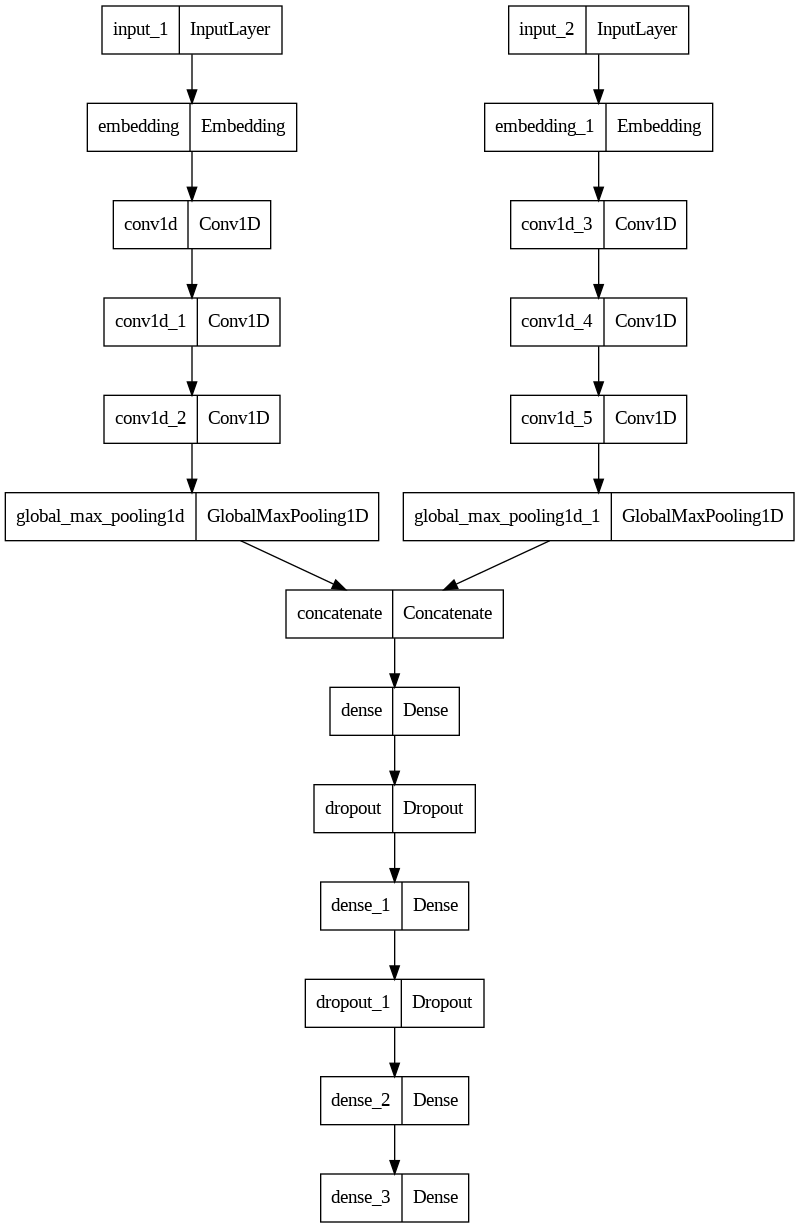

In [22]:
# visualize the model
tf.keras.utils.plot_model(model)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 85)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1200)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 85, 128)              3968      ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1200, 128)            2688      ['input_2[0][0]']             
                                                                                              

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta = 0.01, #minimum amout of change to count as an improvement
    patience = 5, #how many epochs to wait before stopping
    restore_best_weights = True,
)

history = model.fit([train_smiles_array, train_proteins_array], train_labels_array,
                    epochs = 500, batch_size = 32, validation_data = ([test_smiles_array, test_proteins_array], test_labels_array), callbacks=[early_stopping])

Epoch 1/500
520/520 [==============================] - 20s 19ms/step - loss: 1.3891 - mse: 1.3891 - val_loss: 0.9689 - val_mse: 0.9689
Epoch 2/500
520/520 [==============================] - 8s 15ms/step - loss: 0.8681 - mse: 0.8681 - val_loss: 0.7683 - val_mse: 0.7683
Epoch 3/500
520/520 [==============================] - 7s 14ms/step - loss: 0.8388 - mse: 0.8388 - val_loss: 0.7227 - val_mse: 0.7227
Epoch 4/500
520/520 [==============================] - 8s 15ms/step - loss: 0.8112 - mse: 0.8112 - val_loss: 0.7735 - val_mse: 0.7735
Epoch 5/500
520/520 [==============================] - 7s 14ms/step - loss: 0.7471 - mse: 0.7471 - val_loss: 0.6988 - val_mse: 0.6988
Epoch 6/500
520/520 [==============================] - 8s 15ms/step - loss: 0.6977 - mse: 0.6977 - val_loss: 0.6190 - val_mse: 0.6190
Epoch 7/500
520/520 [==============================] - 8s 15ms/step - loss: 0.6101 - mse: 0.6101 - val_loss: 0.6944 - val_mse: 0.6944
Epoch 8/500
520/520 [==============================] - 7s 14m

<Figure size 640x480 with 0 Axes>

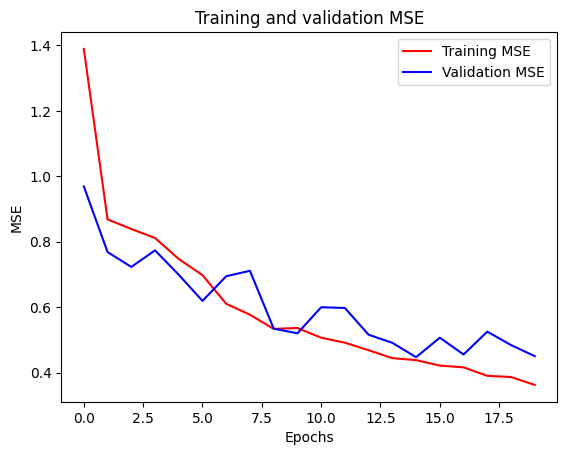

<Figure size 640x480 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt

#---------------------------------------------------------------
# Retrieve a list of list results on training and test data
#Sets for each training epoch
#---------------------------------------------------------------
mse = history.history['mse']
val_mse = history.history['val_mse']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mse)) #Get number of epochs

#---------------------------------------------------------------
# Plot training and validation mse per epoch
#----------------------------------------------------------------
plt.plot(epochs, mse, 'r')
plt.plot(epochs, val_mse, 'b')
plt.title("Training and validation MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(["Training MSE", "Validation MSE"])

plt.figure()

In [26]:
model.save("replicating_deepDTA_0.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Make predications**

In [27]:
# Function to predict drug-protein pKd

def predict_pKd(drug, protein):
    drug_sequence = tokenizer_smiles.texts_to_sequences([drug])
    drug_padded = pad_sequences(drug_sequence, truncating= "post", padding = "post", maxlen = 85)
    protein_sequence = tokenizer_proteins.texts_to_sequences([protein])
    protein_padded = pad_sequences(protein_sequence, truncating = "post", padding = "post", maxlen = 1200)
    prediction = model.predict([tf.expand_dims(drug_padded, axis = -1), tf.expand_dims(protein_padded, axis = -1)])

    return(prediction.item())

In [28]:
drug = test_smiles[131]
protein = test_proteins[131]
label = test_labels[131]

print(label)
predict_pKd(drug = drug, protein = protein)

5.346787486
1/1 [==============================] - 1s 517ms/step


5.145613670349121

In [29]:
test_labels.index(max(test_labels))

1232